# EDA & Feature Engineering

# Library and data import

In [1]:
#import libraries
import numpy as np
import pandas as pd
from metpy.units import units
from metpy.calc import relative_humidity_from_dewpoint
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 25)


In [2]:
# import train_cleaned clean
train_cleaned = pd.read_csv("../output_data/train_clean.csv")

# import weather clean
weather_cleaned = pd.read_csv("../output_data/weather_clean.csv")

# import spray clean
spray_cleaned = pd.read_csv("../output_data/spray_clean.csv")

# Functions used

In [3]:
# plot correlation heatmap
def plot_heatmap(dataframe):
    plt.figure(figsize = (12,8))
    corr = dataframe.corr()

    # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    # Generate heatmap
    sns.heatmap(corr, mask = mask, cmap=sns.color_palette("RdBu_r",7),\
                annot=False, fmt=".2f", cbar_kws = {'shrink': 0.5}, square = True,\
               linewidths = 0.1, vmin=-1, vmax = 1)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    
# function to calculate relative humidity
def cal_rh(temp, dewpoint):
    rh = relative_humidity_from_dewpoint(temperature= temp * units.fahrenheit, 
                                         dewpoint= dewpoint * units.fahrenheit).magnitude
    return rh

# Train Feature Engineering and EDA 

In [4]:
train_cleaned.head()

,date,species,trap,addressnumberandstreet,latitude,longitude,nummosquitos,wnvpresent
0,2007-05-29,PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0
1,2007-05-29,RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0
2,2007-05-29,RESTUANS,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,1,0
3,2007-05-29,PIPIENS/RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,1,0
4,2007-05-29,RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,4,0


### Mosquito Species 

The ability of different mosquito species to acquire and transmit West Nile Virus (WNV) is highly variable. Culex mosquitoes are accepted as the dominant global transmission vector of WNV to humans; but their transmission rates among various species of the Culex genus may vary widely. As a result, it will be worth investigating which Culex mosquito species is the most dominant vector.



According to source <sup>[(1)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3485754/)</sup>, Culex Tarsalis is the main mosquito vector of WNV in the USA, and is capable of injecting the virus into a variety of mammalian and avian hosts. Culex pipiens, Culex restuans, and Culex Salinarius are also widely viewed as important mosquito vectors by the scientific community.


In fact, scientists view the mosquito species as a more important variable influencing WNV transmission compared to any other factor (eg. climate and weather). As a result, correct engineering of this feature is extremely pivotal.

In [5]:
# dataframe showing the total number of each species present, as well as frequency of WNV detected by species.
mosquitoes = train_cleaned[["species", "nummosquitos", "wnvpresent"]].groupby(by = "species").sum()
mosquitoes

,nummosquitos,wnvpresent
species,,
ERRATICUS,7,0
PIPIENS,44671,240
PIPIENS/RESTUANS,66268,262
RESTUANS,23431,49
SALINARIUS,145,0
TARSALIS,7,0
TERRITANS,510,0


/Users/JunnYiow/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


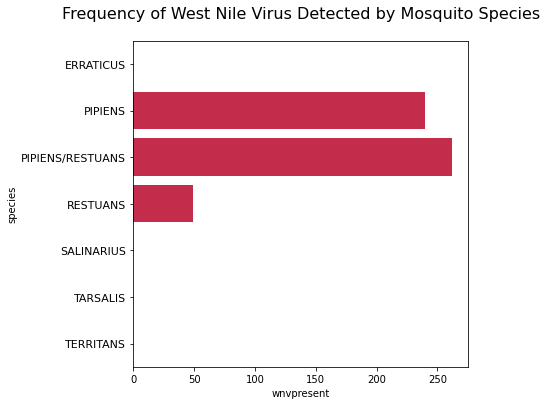

In [6]:
# Plotting a bar chart of frequency of WNV found per mosquito species.
mosquitoes = train_cleaned[["species", "nummosquitos", "wnvpresent"]].groupby(by = "species").sum().reset_index()
plt.figure(figsize = (6,6))
sns.barplot(mosquitoes["wnvpresent"], mosquitoes["species"], color = "crimson")
plt.title("Frequency of West Nile Virus Detected by Mosquito Species", fontsize = 16, y = 1.05)
plt.yticks(fontsize = 11)
plt.show()

In [7]:
# Attempt to normalize mosquito species data by finding the proportion of mosquitoes found 
# that contain the WNV, and using ordinal encoding to rank them based on importance.

# mosquitoes["percentage"] = mosquitoes["wnvpresent"] / mosquitoes["nummosquitos"]
# mosquitoes["percentage"]

<s>Ordinal Encoding of the Mosquito variable based on probability of finding WNV in them.</s>

In [8]:
# train_cleaned["Species"] = train_cleaned["Species"].map({"CULEX ERRATICUS": 0, "CULEX SALINARIUS": 0, "CULEX TARSALIS": 0, "CULEX TERRITANS": 0,
#                                         "CULEX RESTUANS": 1, "CULEX PIPIENS/RESTUANS": 2, "CULEX PIPIENS": 3})

<s>The final engineered feature shows a correlation of 0.122 with the target. Spearman is used because it is a non-parametric measure of correlation, and nothing can be assumed of the underlying mosquito distribution without further analysis (which is out of the scope of this). Pearson would assume that the underlying distribution of mosquitoes follows a Gaussian distribution.</s>

In [9]:
# train_cleaned["species"].corr(train_cleaned["wnvpresent"], method = "spearman")

### Trap Location
Since `trap`, `addressnumberandstreet`, `latitude` and `longitude` all tells us the location of the traps placed, we will only be using `latitude` and `longitude` as these two features would give us the exact coordinates as to where the traps were placed. Hence, we will be dropping the other two features.

In [10]:
# filter all columns related to location
train_cleaned_location = train_cleaned.drop(columns = ['date','species','nummosquitos','wnvpresent'])

# visualising location features
train_cleaned_location.value_counts().sort_index().head(20)

trap  addressnumberandstreet               latitude   longitude 
T001  4000  N TRIPP AVE, Chicago, IL       41.953705  -87.733974     15
T002  4100  N OAK PARK AVE, Chicago, IL    41.954690  -87.800991    185
T003  4600  N MILWAUKEE AVE, Chicago, IL   41.964242  -87.757639    122
T004  4900  W SUNNYSIDE AVE, Chicago, IL   41.962728  -87.748367     12
T005  6000  W ROSCOE ST, Chicago, IL       41.942114  -87.776385     14
T006  6000  N AVONDALE AVE, Chicago, IL    41.990284  -87.797127     24
T007  6200  N MANDELL AVE, Chicago, IL     41.994991  -87.769279     23
T008  7000  N MOSELL AVE, Chicago, IL      42.008314  -87.777921    139
T009  9100  W HIGGINS AVE, Chicago, IL     41.981964  -87.812827     31
      9100  W HIGGINS RD, Chicago, IL      41.992478  -87.862995     80
T011  3600  N PITTSBURGH AVE, Chicago, IL  41.944869  -87.832763    133
T012  6100  N LEMONT AVE, Chicago, IL      41.991429  -87.747113    105
T013  6100  W FULLERTON AVE, Chicago, IL   41.923738  -87.785288    104

In [11]:
# dropping 'trap' and 'addressnumberandstreet' from our train_cleaned dataset
train_cleaned.drop(columns = ['trap','addressnumberandstreet'], inplace = True)

# Weather Feature Engineering and EDA

Research on NCBI suggests that weather is an extremely important factor influencing the mosquito lifecycle, with infection and dissemination rates positively correlating with temperatures (especially above 77 degrees Fahrenheit).

The most important weather factors are:
- Average temperature
- Relative humidity
- Rainfall/precipitation rates
- Temperature fluctuation
- Light intensity


The Koppen weather classification classifies Chicago as a hot summer humid continental.

Most laboratory mosquito research appears to elucidate the relationship between a static temperature and mosquito vector growth rate/ WNV transmission rates. However, in reality, temperature is not perfectly controlled, and instead follows a stochastic pattern. There is insufficient data displaying the effect of a fluctuating or dynamic temperature system on WNV replication and transmission rates.

Instead, research regarding a closely related virus in the flavivirus family, Zika, found that as temperature fluctuations increases, it decreases the ability of mosquitos to transmit the virus. As a result, a variable measuring the fluctuation of temperature would be engineered. As climate change intensifies, the importance of this variable will heighten.

In [12]:
weather_cleaned["temp_fluct"] = weather_cleaned["tmax"] - weather_cleaned["tmin"]

Research on NCBI shows that light intensity is also a critical factor to look at. The steps below show data preparation before engineering of the "daylight" variable as an approximation to light intensity, operationalized by sunset - sunrise. Although this variable shows colinearity with average temperature, laboratory mosquito research has successfully isolated the two, and proven that light intensity alone (independent of temperature increase) would increase important biological steps in the WNV transmission process.

In [13]:
weather_cleaned.dtypes

station          int64
date            object
tmax             int64
tmin             int64
tavg           float64
depart         float64
dewpoint         int64
wetbulb        float64
heat           float64
cool           float64
sunrise         object
sunset          object
preciptotal    float64
stnpressure    float64
sealevel       float64
resultspeed    float64
resultdir        int64
avgspeed       float64
temp_fluct       int64
dtype: object

In [14]:
weather_cleaned['date'] = pd.to_datetime(weather_cleaned['date'])
weather_cleaned['year'] = weather_cleaned['date'].dt.year
weather_cleaned['mth_day'] = weather_cleaned['date'].dt.strftime("%m-%d")
weather_cleaned['week'] = weather_cleaned['date'].dt.isocalendar().week.astype(int)

In [15]:
#new feature - daylight
weather_cleaned['daylight'] = (weather_cleaned['sunset'].astype('datetime64') - 
                       weather_cleaned['sunrise'].astype('datetime64')).dt.seconds/3600

In [16]:
weather_cleaned['relative_hum'] = weather_cleaned.apply(lambda x: cal_rh(x['tavg'], x['dewpoint']), axis =1)

Text(0, 0.5, 'Total Precipitation (inches)')

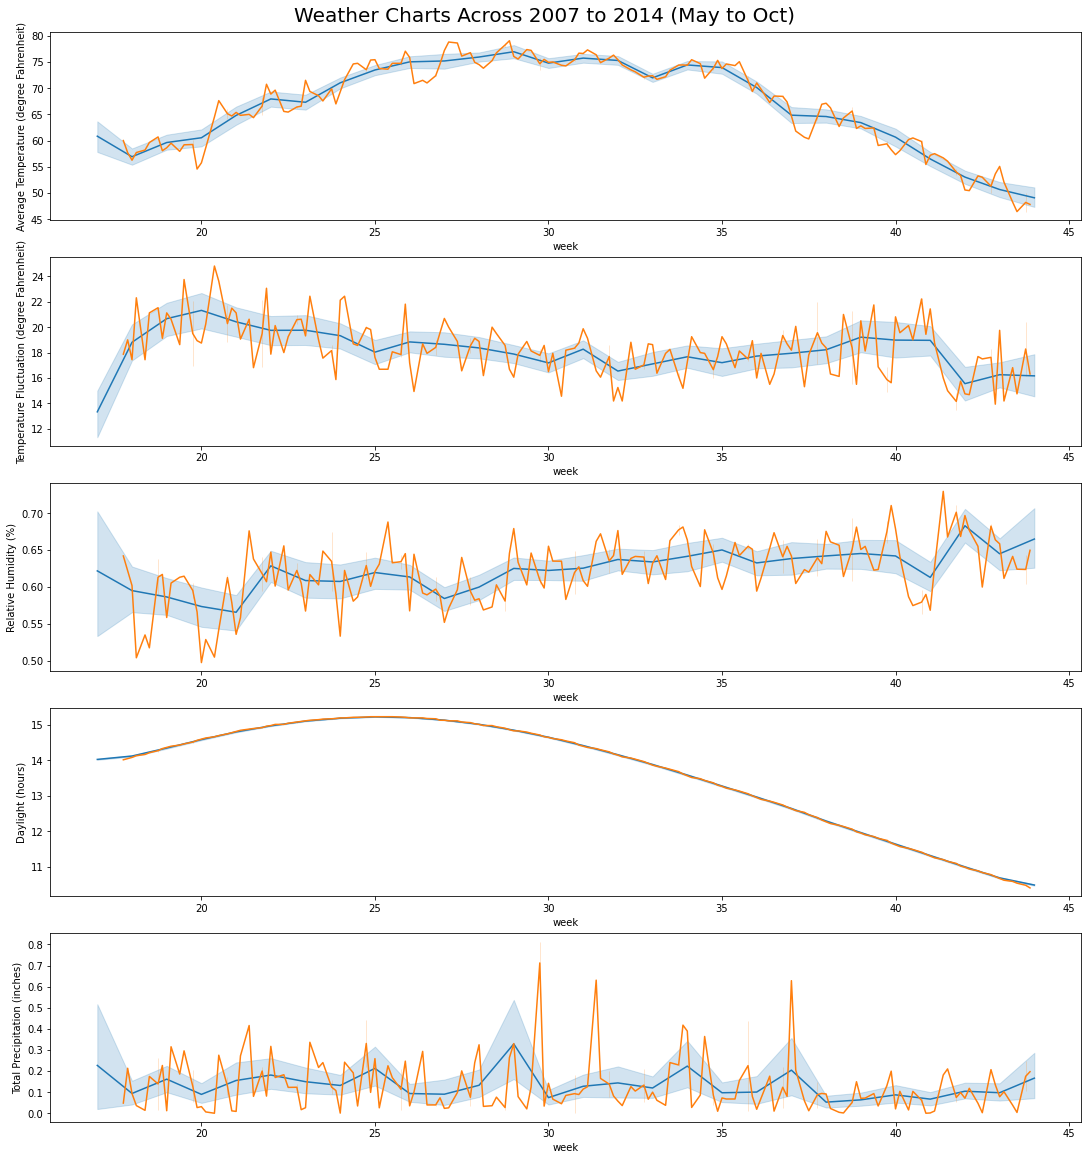

In [17]:
# plot weather charts using average across all years
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15,16), constrained_layout=True)
fig.suptitle("Weather Charts Across 2007 to 2014 (May to Oct)", fontsize = 20)

sns.lineplot(data=weather_cleaned, x='week', y='tavg', ax=ax[0])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='tavg',ax=ax[0]);

sns.lineplot(data=weather_cleaned, x='week', y='temp_fluct', ax=ax[1])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='temp_fluct',ax=ax[1]);

sns.lineplot(data=weather_cleaned, x='week', y='relative_hum', ax=ax[2])
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='relative_hum',ax=ax[2]);

sns.lineplot(data=weather_cleaned, x='week', y='daylight', ax=ax[3]);
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='daylight', ax=ax[3]);

sns.lineplot(data=weather_cleaned, x='week', y='preciptotal', ax=ax[4]);
sns.lineplot(data=weather_cleaned.groupby('mth_day').mean(), x='week', y='preciptotal', ax=ax[4]);

ax[0].set_ylabel("Average Temperature (degree Fahrenheit)")
ax[1].set_ylabel("Temperature Fluctuation (degree Fahrenheit)")
ax[2].set_ylabel("Relative Humidity (%)")
ax[3].set_ylabel("Daylight (hours)")
ax[4].set_ylabel("Total Precipitation (inches)")

In [18]:
#create function for plotting
def plot_func(dataframe, attr, **kwarg):
    ''' Plot histogram, scatter plot, box plot, and qq plot in a figure.
    
    Note: 
    - For scatter plot, the attribute is plotted agaist saleprice.
    - Box plot is overlaid with strip plot to provide a sense of distribution of the data. 
    - There for categorical features, there will be no qq plot
    
    Parameters:
    data (dataframe): pandas dataframe 
    attr (list): list of dataframe column names to be plotted
    kwarg (string): accept attr: saleprice

    Returns:
    Nil'''
    row = len(attr)
    col = 3
    figsize = (20, row*4)
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=figsize, constrained_layout=True) 
    for x in range(row):
            #histogram plot
            sns.histplot(x=attr[x], data=dataframe, ax=ax[x,0], color='tab:red', )
            ax[x, 0].set_title(f'histogram: {attr[x]}')
            ax[x, 0].tick_params(labelrotation=90, axis='x')
            #scatter plot
            sns.scatterplot(x='week', y=attr[x], data=dataframe, ax=ax[x,1])
            ax[x, 1].set_title(f'scatter plot: {attr[x]}')
            ax[x, 1].tick_params(labelrotation=90, axis='x')
            #scatter plot
            sns.scatterplot(x='week', y=attr[x], data=dataframe, ax=ax[x,1])
            ax[x, 1].set_title(f'scatter plot: {attr[x]}')
            ax[x, 1].tick_params(labelrotation=90, axis='x')
            #box plot
            
            #box plot
            sns.boxplot(x=attr[x], data=dataframe, ax=ax[x,2])
            sns.stripplot(x=attr[x], data=dataframe, ax=ax[x,2], alpha= 0.2)
            ax[x, 2].set_title(f'boxplot: {attr[x]}')
            ax[x, 2].tick_params(labelrotation=90, axis='x')
            
    plt.show()

In [19]:
num_features = weather_cleaned.select_dtypes(include='number').columns.to_list()
cat_features = weather_cleaned.select_dtypes(exclude='number').columns.to_list()

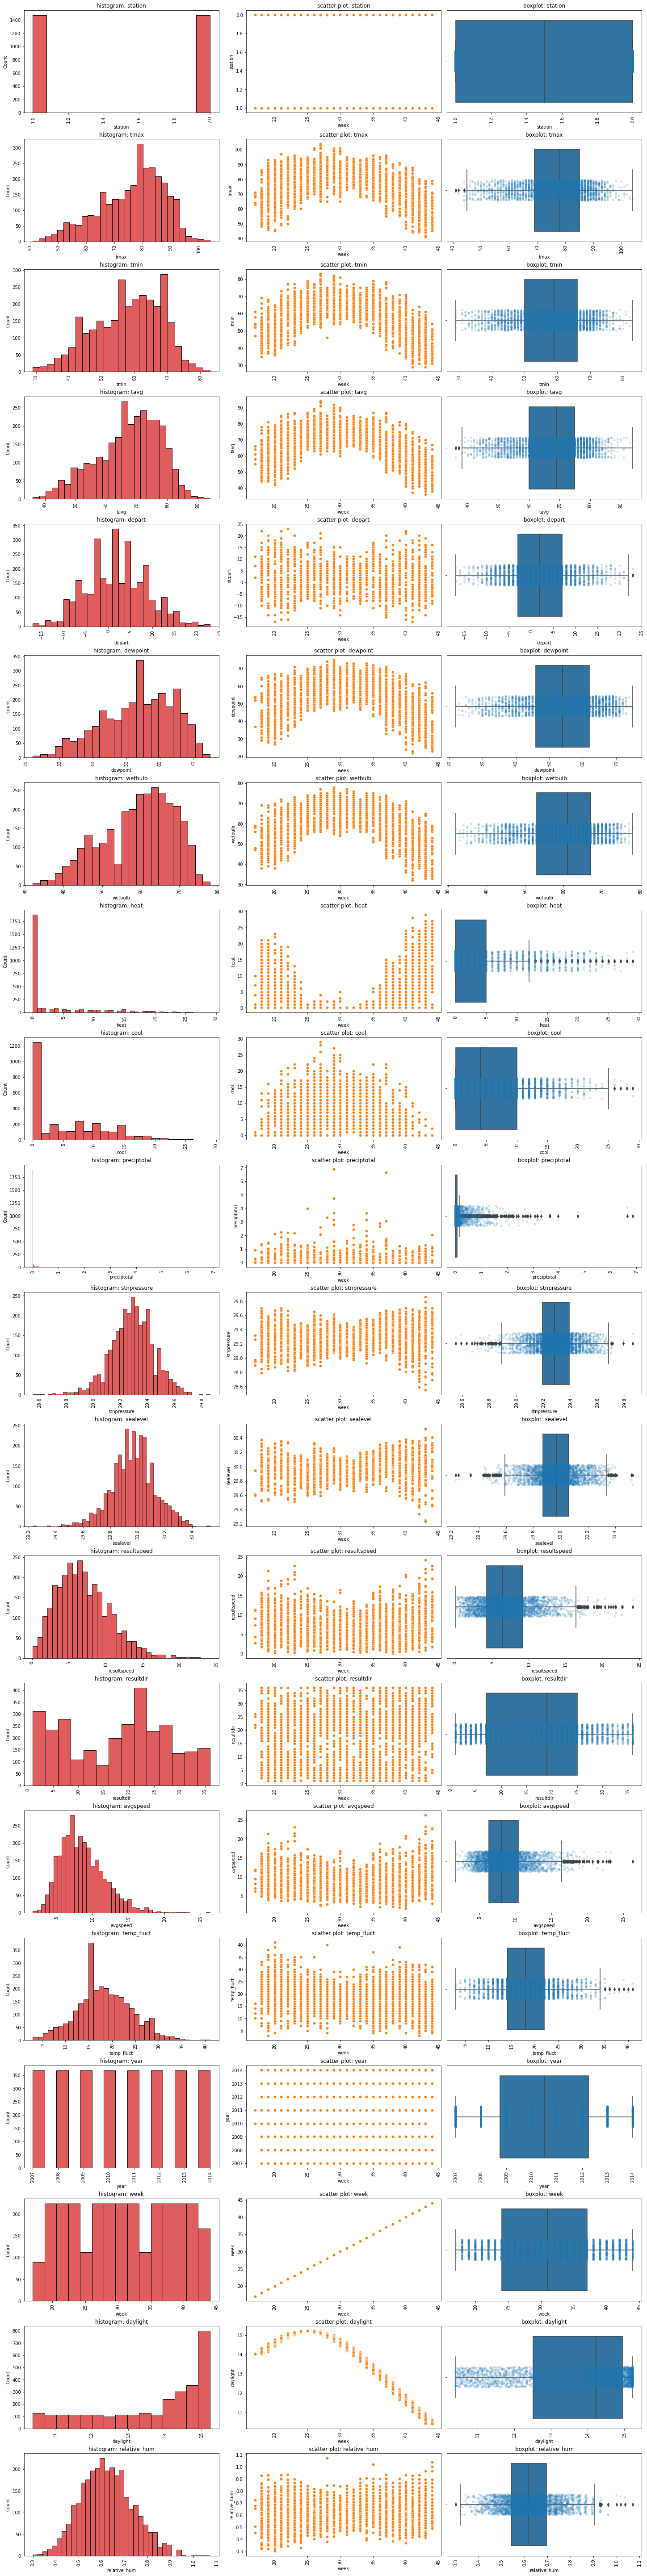

In [20]:
plot_func(weather_cleaned, num_features)

<AxesSubplot:>

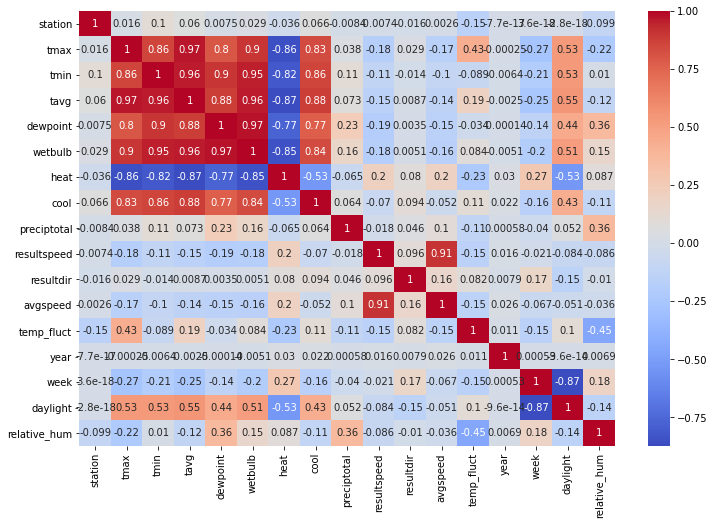

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(weather_cleaned.drop(columns=['depart','stnpressure','sealevel']).corr(), cmap='coolwarm', annot=True)

In [22]:
weather_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       2944 non-null   int64         
 1   date          2944 non-null   datetime64[ns]
 2   tmax          2944 non-null   int64         
 3   tmin          2944 non-null   int64         
 4   tavg          2944 non-null   float64       
 5   depart        2944 non-null   float64       
 6   dewpoint      2944 non-null   int64         
 7   wetbulb       2944 non-null   float64       
 8   heat          2944 non-null   float64       
 9   cool          2944 non-null   float64       
 10  sunrise       2944 non-null   object        
 11  sunset        2944 non-null   object        
 12  preciptotal   2944 non-null   float64       
 13  stnpressure   2944 non-null   float64       
 14  sealevel      2944 non-null   float64       
 15  resultspeed   2944 non-null   float64 

In [23]:
weather_cleaned.shape

(2944, 24)

In [24]:
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])

In [25]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10506 non-null  datetime64[ns]
 1   species       10506 non-null  object        
 2   latitude      10506 non-null  float64       
 3   longitude     10506 non-null  float64       
 4   nummosquitos  10506 non-null  int64         
 5   wnvpresent    10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 492.6+ KB


In [26]:
merged = train_cleaned.merge(weather_cleaned.groupby('date').mean(), on='date', how='left')
merged

,date,species,latitude,longitude,nummosquitos,wnvpresent,station,tmax,tmin,tavg,depart,dewpoint,...,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,temp_fluct,year,week,daylight,relative_hum
0,2007-05-29,PIPIENS/RESTUANS,41.954690,-87.800991,1,0,1.5,88.0,62.5,75.5,10.0,58.5,...,10.5,0.0,29.415,30.10,5.80,17.0,6.95,25.5,2007.0,22.0,14.933333,0.555840
1,2007-05-29,RESTUANS,41.954690,-87.800991,1,0,1.5,88.0,62.5,75.5,10.0,58.5,...,10.5,0.0,29.415,30.10,5.80,17.0,6.95,25.5,2007.0,22.0,14.933333,0.555840
2,2007-05-29,RESTUANS,41.994991,-87.769279,1,0,1.5,88.0,62.5,75.5,10.0,58.5,...,10.5,0.0,29.415,30.10,5.80,17.0,6.95,25.5,2007.0,22.0,14.933333,0.555840
3,2007-05-29,PIPIENS/RESTUANS,41.974089,-87.824812,1,0,1.5,88.0,62.5,75.5,10.0,58.5,...,10.5,0.0,29.415,30.10,5.80,17.0,6.95,25.5,2007.0,22.0,14.933333,0.555840
4,2007-05-29,RESTUANS,41.974089,-87.824812,4,0,1.5,88.0,62.5,75.5,10.0,58.5,...,10.5,0.0,29.415,30.10,5.80,17.0,6.95,25.5,2007.0,22.0,14.933333,0.555840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,PIPIENS/RESTUANS,41.763733,-87.742302,6,1,1.5,75.0,52.5,64.0,3.0,52.0,...,0.0,0.0,29.370,30.04,3.95,8.5,4.40,22.5,2013.0,39.0,11.983333,0.650185
10502,2013-09-26,PIPIENS/RESTUANS,41.987280,-87.666066,5,0,1.5,75.0,52.5,64.0,3.0,52.0,...,0.0,0.0,29.370,30.04,3.95,8.5,4.40,22.5,2013.0,39.0,11.983333,0.650185
10503,2013-09-26,PIPIENS/RESTUANS,41.912563,-87.668055,1,0,1.5,75.0,52.5,64.0,3.0,52.0,...,0.0,0.0,29.370,30.04,3.95,8.5,4.40,22.5,2013.0,39.0,11.983333,0.650185
10504,2013-09-26,PIPIENS/RESTUANS,42.009876,-87.807277,5,0,1.5,75.0,52.5,64.0,3.0,52.0,...,0.0,0.0,29.370,30.04,3.95,8.5,4.40,22.5,2013.0,39.0,11.983333,0.650185


In [27]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10506 non-null  datetime64[ns]
 1   species       10506 non-null  object        
 2   latitude      10506 non-null  float64       
 3   longitude     10506 non-null  float64       
 4   nummosquitos  10506 non-null  int64         
 5   wnvpresent    10506 non-null  int64         
 6   station       10506 non-null  float64       
 7   tmax          10506 non-null  float64       
 8   tmin          10506 non-null  float64       
 9   tavg          10506 non-null  float64       
 10  depart        10506 non-null  float64       
 11  dewpoint      10506 non-null  float64       
 12  wetbulb       10506 non-null  float64       
 13  heat          10506 non-null  float64       
 14  cool          10506 non-null  float64       
 15  preciptotal   10506 non-null  float6

<AxesSubplot:>

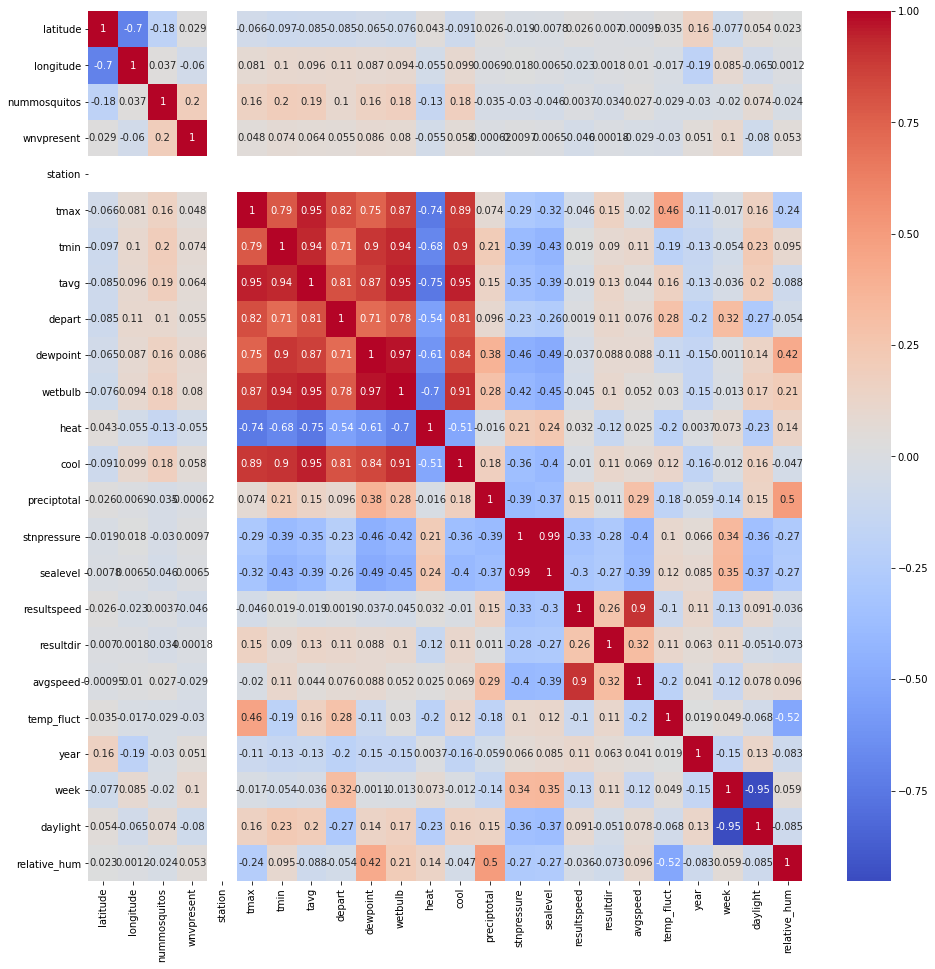

In [28]:
plt.figure(figsize=(16,16))
sns.heatmap(merged.corr(), cmap='coolwarm', annot=True)

In [29]:
merged.to_csv('../output_data/merged_train.csv', index= False)